# Importing required libraries

In [3]:
%run ./EODHD_Functions.ipynb
%run ./Option_Pricing_Models.ipynb
import requests
import pandas as pd
import datetime as dt
import numpy as np
import os as os
from textblob import TextBlob
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import matplotlib.pyplot as mdates
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import numpy as np
from datetime import datetime
import numpy as np
import itertools
import matplotlib.pyplot as plt

# Using option pricing models to price a call option

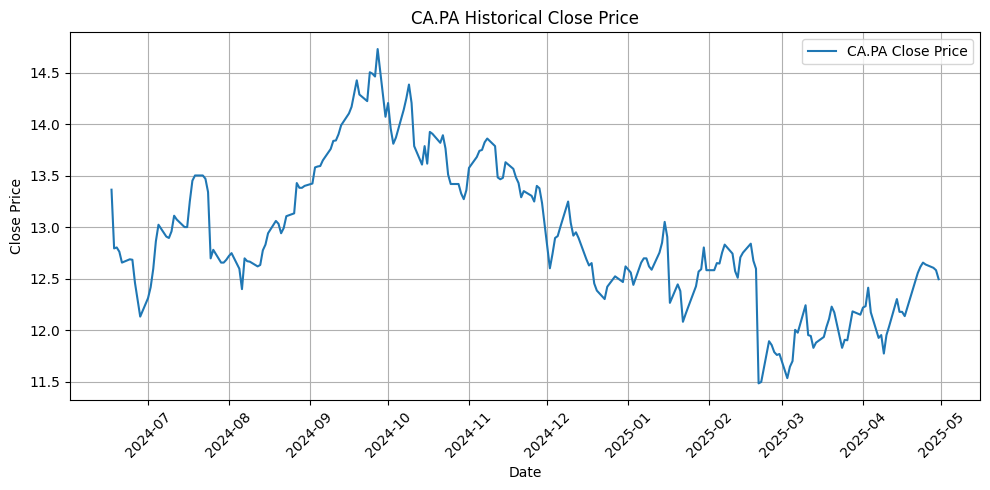

In [4]:
# Fitting existing data with jump diffusion model
Function = EODHD_Functions()
start_date = "2024-06-15"
end_date = "2025-05-01"

# Convert strings to datetime objects
start_dt = datetime.strptime(start_date, "%Y-%m-%d")
end_dt = datetime.strptime(end_date, "%Y-%m-%d")

# Calculate the difference in days
num_days = (end_dt - start_dt).days

CA = Function.Fetch_historical_price("CA.PA", start_date, end_date, "d")


# Convert 'date' column to datetime if not already
CA['date'] = pd.to_datetime(CA['date'])

# Plot the historical price data with correct year-month labels on x-axis
plt.figure(figsize=(10, 5))
plt.plot(CA['date'], CA['adjusted_close'], label='CA.PA Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('CA.PA Historical Close Price')
plt.legend()
plt.grid(True)

# Format x-axis to show year-month (YYYY-MM)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Best Fitted Parameters:
mu = -0.1579
lamb = 0.5337
mu_j = 1.1579
sigma_j = 1.4763
Best Model fit (R^2): 59.35%


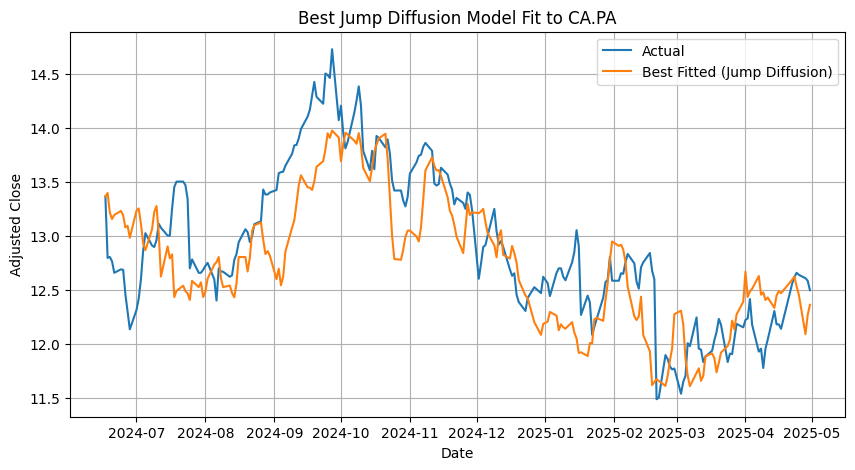

In [10]:
# Grid search for best parameters
mu_range = np.linspace(-1, 1, 30)
lamb_range = np.linspace(0.01, 12.0, 30)
mu_j_range = np.linspace(-0.1, 1.0, 30)
sigma_j_range = np.linspace(0.01, 0.1, 30)

S0 = CA['adjusted_close'].iloc[0]
actual_prices = CA['adjusted_close'].values
N = len(actual_prices)
T = num_days / 252
sigma = Calculate_volatility(CA, 30)

best_r2 = -np.inf
best_params = None
best_fit = None

for mu, lamb, mu_j, sigma_j in itertools.product(mu_range, lamb_range, mu_j_range, sigma_j_range):
    t, simulated = simulate_jump_diffusion(S0, mu, sigma, lamb, mu_j, sigma_j, T, N)
    simulated = np.asarray(simulated).flatten()
    if simulated.shape[0] != actual_prices.shape[0]:
        simulated = np.interp(
            np.arange(len(actual_prices)),
            np.linspace(0, len(actual_prices)-1, len(simulated)),
            simulated
        )
    simulated[0] = actual_prices[0]
    ss_res = np.sum((actual_prices - simulated)**2)
    ss_tot = np.sum((actual_prices - np.mean(actual_prices))**2)
    r2 = 1 - ss_res/ss_tot
    if r2 > best_r2:
        best_r2 = r2
        best_params = (mu, lamb, mu_j, sigma_j)
        best_fit = simulated

fit_percent = best_r2 * 100
mu_fit, lamb_fit, mu_j_fit, sigma_j_fit = best_params

print(f"Best Fitted Parameters:\nmu = {mu_fit:.4f}\nlamb = {lamb_fit:.4f}\nmu_j = {mu_j_fit:.4f}\nsigma_j = {sigma_j_fit:.4f}")
print(f"Best Model fit (R^2): {fit_percent:.2f}%")

# Plot actual vs best fitted
plt.figure(figsize=(10,5))
plt.plot(CA['date'], actual_prices, label='Actual')
plt.plot(CA['date'], best_fit, label='Best Fitted (Jump Diffusion)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.title('Best Jump Diffusion Model Fit to CA.PA')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp
#Optimzied version

def evaluate_params(param_chunk, S0, sigma, T, N, actual_prices):
    """Evaluate a chunk of parameters and return best result"""
    best_r2 = -np.inf
    best_params = None
    best_fit = None
    
    # Pre-calculate constants
    actual_mean = np.mean(actual_prices)
    ss_tot = np.sum((actual_prices - actual_mean)**2)
    
    for mu, lamb, mu_j, sigma_j in param_chunk:
        try:
            t, simulated = simulate_jump_diffusion(S0, mu, sigma, lamb, mu_j, sigma_j, T, N)
            simulated = np.asarray(simulated).flatten()
            
            # Vectorized interpolation check
            if simulated.shape[0] != actual_prices.shape[0]:
                simulated = np.interp(
                    np.arange(len(actual_prices)),
                    np.linspace(0, len(actual_prices)-1, len(simulated)),
                    simulated
                )
            
            simulated[0] = actual_prices[0]
            
            # Vectorized R² calculation
            ss_res = np.sum((actual_prices - simulated)**2)
            r2 = 1 - ss_res/ss_tot
            
            if r2 > best_r2:
                best_r2 = r2
                best_params = (mu, lamb, mu_j, sigma_j)
                best_fit = simulated.copy()
                
        except Exception:
            continue  # Skip invalid parameter combinations
            
    return best_r2, best_params, best_fit

# Optimized grid search with parallel processing
mu_range = np.linspace(-1, 1, 30)  # Reduced grid size for speed
lamb_range = np.linspace(0.01, 12.0, 30)
mu_j_range = np.linspace(-0.1, 1.0, 30)
sigma_j_range = np.linspace(0.01, 0.1, 30)

S0 = CA['adjusted_close'].iloc[0]
actual_prices = CA['adjusted_close'].values
N = len(actual_prices)
T = num_days / 252
sigma = Calculate_volatility(CA, 30)

# Create parameter combinations and split into chunks
all_params = list(itertools.product(mu_range, lamb_range, mu_j_range, sigma_j_range))
n_cores = min(mp.cpu_count(), 8)  # Use max 8 cores
chunk_size = len(all_params) // n_cores
param_chunks = [all_params[i:i + chunk_size] for i in range(0, len(all_params), chunk_size)]

print(f"Testing {len(all_params):,} parameter combinations using {n_cores} cores...")

# Parallel processing
best_r2 = -np.inf
best_params = None
best_fit = None

with ProcessPoolExecutor(max_workers=n_cores) as executor:
    futures = [executor.submit(evaluate_params, chunk, S0, sigma, T, N, actual_prices) 
               for chunk in param_chunks]
    
    for i, future in enumerate(futures):
        try:
            r2, params, fit = future.result()
            if r2 > best_r2:
                best_r2 = r2
                best_params = params
                best_fit = fit
            print(f"Chunk {i+1}/{len(futures)} completed, best R² so far: {best_r2:.4f}")
        except Exception as e:
            print(f"Chunk {i+1} failed: {e}")

fit_percent = best_r2 * 100
mu_fit, lamb_fit, mu_j_fit, sigma_j_fit = best_params

# Convert to percentage for display
mu_j_percent = (np.exp(mu_j_fit) - 1) * 100
sigma_j_percent = (np.exp(sigma_j_fit) - 1) * 100

print(f"\nBest Fitted Parameters:")
print(f"mu = {mu_fit:.4f}")
print(f"lamb = {lamb_fit:.4f}")
print(f"mu_j = {mu_j_fit:.4f} (log scale) = {mu_j_percent:.2f}% (percentage)")
print(f"sigma_j = {sigma_j_fit:.4f} (log scale) = {sigma_j_percent:.2f}% (percentage)")
print(f"Best Model fit (R²): {fit_percent:.2f}%")

# Plot actual vs best fitted
plt.figure(figsize=(12, 6))
plt.plot(CA['date'], actual_prices, label='Actual', linewidth=2, color='blue')
plt.plot(CA['date'], best_fit, label='Best Fitted (Jump Diffusion)', linewidth=2, color='red', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.title(f'Best Jump Diffusion Model Fit to CA.PA (R² = {fit_percent:.2f}%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Testing 810,000 parameter combinations using 8 cores...


In [ ]:
# Use fitted parameters to simulate jump diffusion and price options
strike = 16
num_simulations = 20000
call_prices = []
put_prices = []

end_date = dt.datetime.now()
days = 30
trading_days = 252
start_date = end_date - dt.timedelta(days=days)
Pricing_CA = Function.Fetch_historical_price("CA.PA", start_date,end_date,"d")
S0 = Pricing_CA['adjusted_close'].iloc[-1]
Pricing_sigma = Calculate_volatility(Pricing_CA, 30)
rf = Function.Fetch_macroecon_data('FR1M.GBOND')['adjusted_close'].iloc[-1]

for _ in range(num_simulations):
    t_sim, simulated_prices = simulate_jump_diffusion(
        S0, mu_fit, Pricing_sigma, lamb_fit, mu_j_fit, sigma_j_fit, T=days/trading_days, N=days
    )
    ST = simulated_prices[-1]
    call_payoff = max(ST - strike, 0)
    put_payoff = max(strike - ST, 0)
    call_prices.append(call_payoff)
    put_prices.append(put_payoff)

call_option_price = (np.mean(call_prices))/(1+(rf/100)**(days/trading_days))
put_option_price = (np.mean(put_prices))/(1+(rf/100)**(days/trading_days))

print(f"Estimated Call Option Price (K={strike}): {call_option_price:.4f}")
print(f"Estimated Put Option Price (K={strike}): {put_option_price:.4f}")

Estimated Call Option Price (K=16): 13.1903
Estimated Put Option Price (K=16): 2.4887


/tmp/ipykernel_49870/4055771008.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


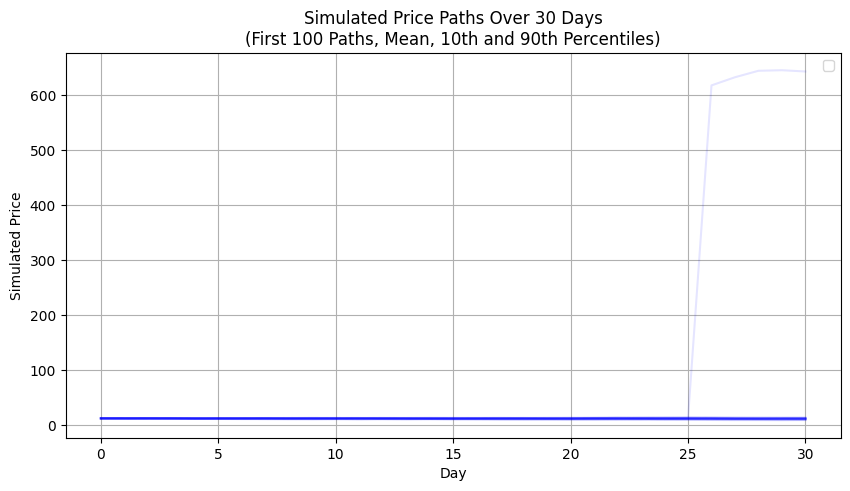

In [ ]:
simulated_matrix = []

for _ in range(num_simulations):
    t_sim, simulated_prices = simulate_jump_diffusion(
        S0, mu_fit, Pricing_sigma, lamb_fit, mu_j_fit, sigma_j_fit, T=days/trading_days, N=days
    )
    ST = simulated_prices[-1]
    call_payoff = max(ST - strike, 0)
    put_payoff = max(strike - ST, 0)
    call_prices.append(call_payoff)
    put_prices.append(put_payoff)
    simulated_matrix.append(simulated_prices)

simulated_matrix = np.array(simulated_matrix)
mean_sim = np.mean(simulated_matrix, axis=0)
p10_sim = np.percentile(simulated_matrix, 10, axis=0)
p90_sim = np.percentile(simulated_matrix, 90, axis=0)

# Plot a subset of simulated price paths for visualization
plt.figure(figsize=(10, 5))
for i in range(num_simulations):  # plot first 100 simulated paths for clarity
    plt.plot(simulated_matrix[i], color='blue', alpha=0.1)

plt.xlabel('Day')
plt.ylabel('Simulated Price')
plt.title('Simulated Price Paths Over 30 Days\n(First 100 Paths, Mean, 10th and 90th Percentiles)')
plt.legend()
plt.grid(True)
plt.show()

